In [27]:
import pandas as pd
from collections import Counter
import numpy as nm
import matplotlib.pyplot as plt
import warnings
import random
import datetime
warnings.filterwarnings("ignore")
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import cv2 as cv2
import os
import math as m
  

## Negative comments identification
### File Loading & Text Preprocessing

In [28]:
'''
data= pd.read_json("review.json", lines=True, chunksize=100000)
i=1
for c in data:
    c.to_csv("review"+str(i)+".csv", index=False)
    i=i+1
'''   

'\ndata= pd.read_json("review.json", lines=True, chunksize=100000)\ni=1\nfor c in data:\n    c.to_csv("review"+str(i)+".csv", index=False)\n    i=i+1\n'

In [29]:
def prepareData(number, fileName):
    df= pd.DataFrame(columns=["stars", 'text'])
    for c in range(1,number+1):#67
        m=pd.read_csv(fileName+str(c)+".csv")
        
        df=df.append(pd.DataFrame(m[['stars','text']]) ,ignore_index=True)
    df['text']=df['text'].str.replace('\d+', '')
    df= df.dropna(axis=0, how="any")
    print("-------------Missing values--------------")
    print(df.isna().sum())
    print("-----------------------------------------")
    return df

def cleanData(df):
    df['text']=df['text'].apply(lambda x:str(x).translate(str.maketrans('', '', string.punctuation)).lower().rstrip())
    words=stopwords.words('english')
    arr=[]
    for el in df['text']:
        pp=''
        var=el.split()
        for i in var:
            if not i in words:
                pp=pp+i+' '
        arr.append(pp)
    return arr


In [30]:
df= prepareData(3, "review")
df['text']= cleanData(df)
df['text']

-------------Missing values--------------
stars    0
text     0
dtype: int64
-----------------------------------------


0         total bill horrible service gs crooks actually...
1         adore travis hard rocks new kelly cardenas sal...
2         say office really together organized friendly ...
3         went lunch steak sandwich delicious caesar sal...
4         today second three sessions paid although firs...
                                ...                        
299995    truly love great staff knowledgable really car...
299996    worst beer ive ever zero food seriously let ex...
299997    first time location looks recently remodeled a...
299998    loveee bahama bucks used go one back home texa...
299999    review car wash ownership fraudulent practices...
Name: text, Length: 300000, dtype: object

### Splitting dataset into :
- positive comments
- negative comments
- neutral comments

To identify bad buzz we will work with negative

#### Stars ordinal variable distribution before comments allocation

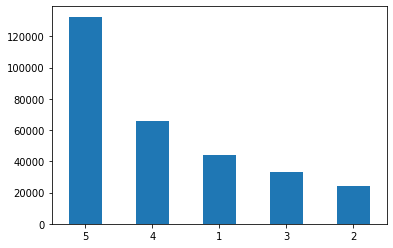

In [31]:
df['stars'].value_counts().plot(kind='bar', rot=0)

In [32]:
positive= df[df['stars']>3]

In [33]:
negative= df[df['stars']<3]

In [34]:
neutral= df[df['stars']==3]

#### Comments allocation into three categories

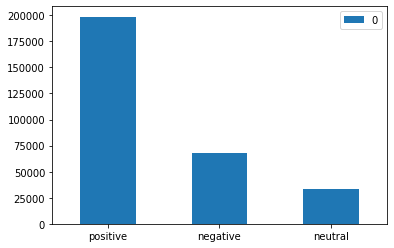

In [35]:
vals=[len(positive['stars']),len(negative['stars']),len(neutral['stars'])]
ind=['positive','negative', 'neutral']
pd.DataFrame(vals, index=ind).plot(kind='bar', rot=0)

### Selecting words that can identify positive and neutral comments
We want to avoid those words in negative comments analysis, because they can represent differnt types of comments
- number 500, available at the least in 20 docs and at the most in 99%. Features of one and two words are accepted
- applied lemmatization


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
def getUsedEverywhere(data1, data2):
    vectorizer2 = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,2), min_df=20, max_df=0.99,max_features=300)
    X2 = vectorizer2.fit_transform(data1)
    featpos=vectorizer2.get_feature_names()
    X2 = vectorizer2.fit_transform(data2)
    featneu=vectorizer2.get_feature_names()

    for i in featpos:
        if not i in featneu:
            featneu.append(i)
    return featneu

def createBOW(data3,typ, words, m):
    if(typ==True):
        tfidfconverter = TfidfVectorizer(tokenizer=LemmaTokenizer(), max_features=500, min_df=m, max_df=0.9, ngram_range=(1,2),stop_words=words)  
    else:
        tfidfconverter = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word', ngram_range=(1, 2), min_df=5, max_df=0.9,max_features=500, stop_words=words)
    X = tfidfconverter.fit_transform(data3)
    df = pd.DataFrame(X.toarray(), columns=tfidfconverter.get_feature_names())
    return df


#### Testing text processing functions

In [40]:
strin = "I believe, I have not eaten this type of food for a week!"
strin2 = "No Way, Never Again!!!...."
strin=pd.DataFrame({'stars':[1], 'text':[strin]})
strin.to_csv('test1.csv', mode='w', index= False, header=strin.columns)
strin=pd.DataFrame({'stars':[2], 'text':[strin2]})
strin.to_csv('test2.csv', mode='w', index= False, header=strin.columns)
strin= prepareData(2,"test")
print(strin)
strin = cleanData(strin)
print(strin)
strin=createBOW(strin,True, [],1)
strin


-------------Missing values--------------
stars    0
text     0
dtype: int64
-----------------------------------------
  stars                                               text
0     1  I believe, I have not eaten this type of food ...
1     2                         No Way, Never Again!!!....
['believe eaten type food week ', 'way never ']


,believe,believe eaten,eaten,eaten type,food,food week,never,type,type food,way,way never,week
0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.00000,0.333333,0.333333,0.00000,0.00000,0.333333
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,0.57735,0.57735,0.000000


### Creating BOW by using TF- IDF measurments
- lemmatization
- 500 fetuares
- ngrams: 1,2
- stopwords: presented in other neutral and negative comments( as well as english stopwords that have been removed earlier)


In [38]:
removeWords=getUsedEverywhere(positive['text'], neutral['text'])
bowtfidf=createBOW(negative['text'],True,removeWords,5)
#bowcount= createBOW(negative['text'],False,removeWords)

In [39]:
bowtfidf

,account,across,add,added,additional,ago,ahead,air,airport,along,...,worse,worst,wow,write,wrong,yelp,yes,yet,young,zero
0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.083139,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.074298,0.0,0.0,0.086099,0.000000,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.250472,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68210,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
68211,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
68212,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
68213,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.145652,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.203868


### Negaive comments have various topics( reason for the comments), lets try to see some general tendencies
- combine words that belongs to various topic and reduce the dimentions
- 15 topics to be chosen

In [43]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=15, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(bowtfidf)

In [44]:
do=pd.DataFrame(index=bowtfidf.columns)
count=0
ftrs=pd.DataFrame(index=range(1,10))
for i in lda.components_:
    
    d= pd.DataFrame(i,index=bowtfidf.columns,columns=[count])
    uu=pd.DataFrame(d.sort_values(by=[count],ascending=False).index[:10])
    ftrs[count]=uu
    do[count]=d
    count=count+1
      
ftrs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,burrito,crab,terrible,employee,min,driver,company,cut,overpriced,credit,can not,closed,party,floor,waste
2,disappointing,rib,smell,worst,seated,pool,appointment,lady,suck,cash,not,thru,club,bathroom,waste money
3,bean,oil,gross,wash,sat,bed,phone,salon,decor,manager,impressed,flight,glass,door,groupon
4,bowl,thai,son,horrible,wing,rental,office,tip,poor,credit card,burnt,wife,loud,street,save
5,onion,salt,disgusting,manager,finally,coupon,doctor,massage,salty,bag,mexican,airport,mediocre,walk,sale
6,salsa,sick,bacon,tire,hostess,company,month,color,bbq,receipt,serve,window,bottle,across,avoid
7,soggy,ate,cheap,cashier,empty,online,insurance,foot,real,register,anymore,ticket,birthday,light,buy
8,lettuce,game,frozen,working,walked,desk,issue,worker,attitude,cause,gone,tonight,dress,school,spend
9,tomato,lobster,eaten,counter,manager,stay,problem,girl,sad,purchase,awful,seat,forever,kitchen,class


### Topics 3D Visualization with help of TSNE

In [53]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
def visualize(do,columns):
    model = TSNE(n_components = 3, perplexity = 50)
    tsne_data = model.fit_transform(do)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(tsne_data)

    dataV=pd.DataFrame(x_scaled, columns=["D1","D2","D3"])

    for i in dataV:
        sd= 1*dataV[i].std()
        mean=dataV[i].mean()
    
        a=dataV[i].apply(lambda x:x if x> mean-sd  else mean-sd)
        dataV[i]=  a.apply(lambda x: x if  x< mean+sd  else mean+sd)
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d')
    plt.title("3D visualization BOW", loc='left')

    xs = dataV["D1"]
    ys = dataV["D2"]
    zs= dataV["D3"]
    ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

    ax.set_xlabel('Dimention 1')
    ax.set_ylabel('Dimention 2')
    ax.set_zlabel('Dimention 3', rotation=90)
    m=0
    for  x, y, z in zip( xs, ys, zs):
    
        label = columns[m]
        ax.text(x, y, z,  label)
        m=m+1


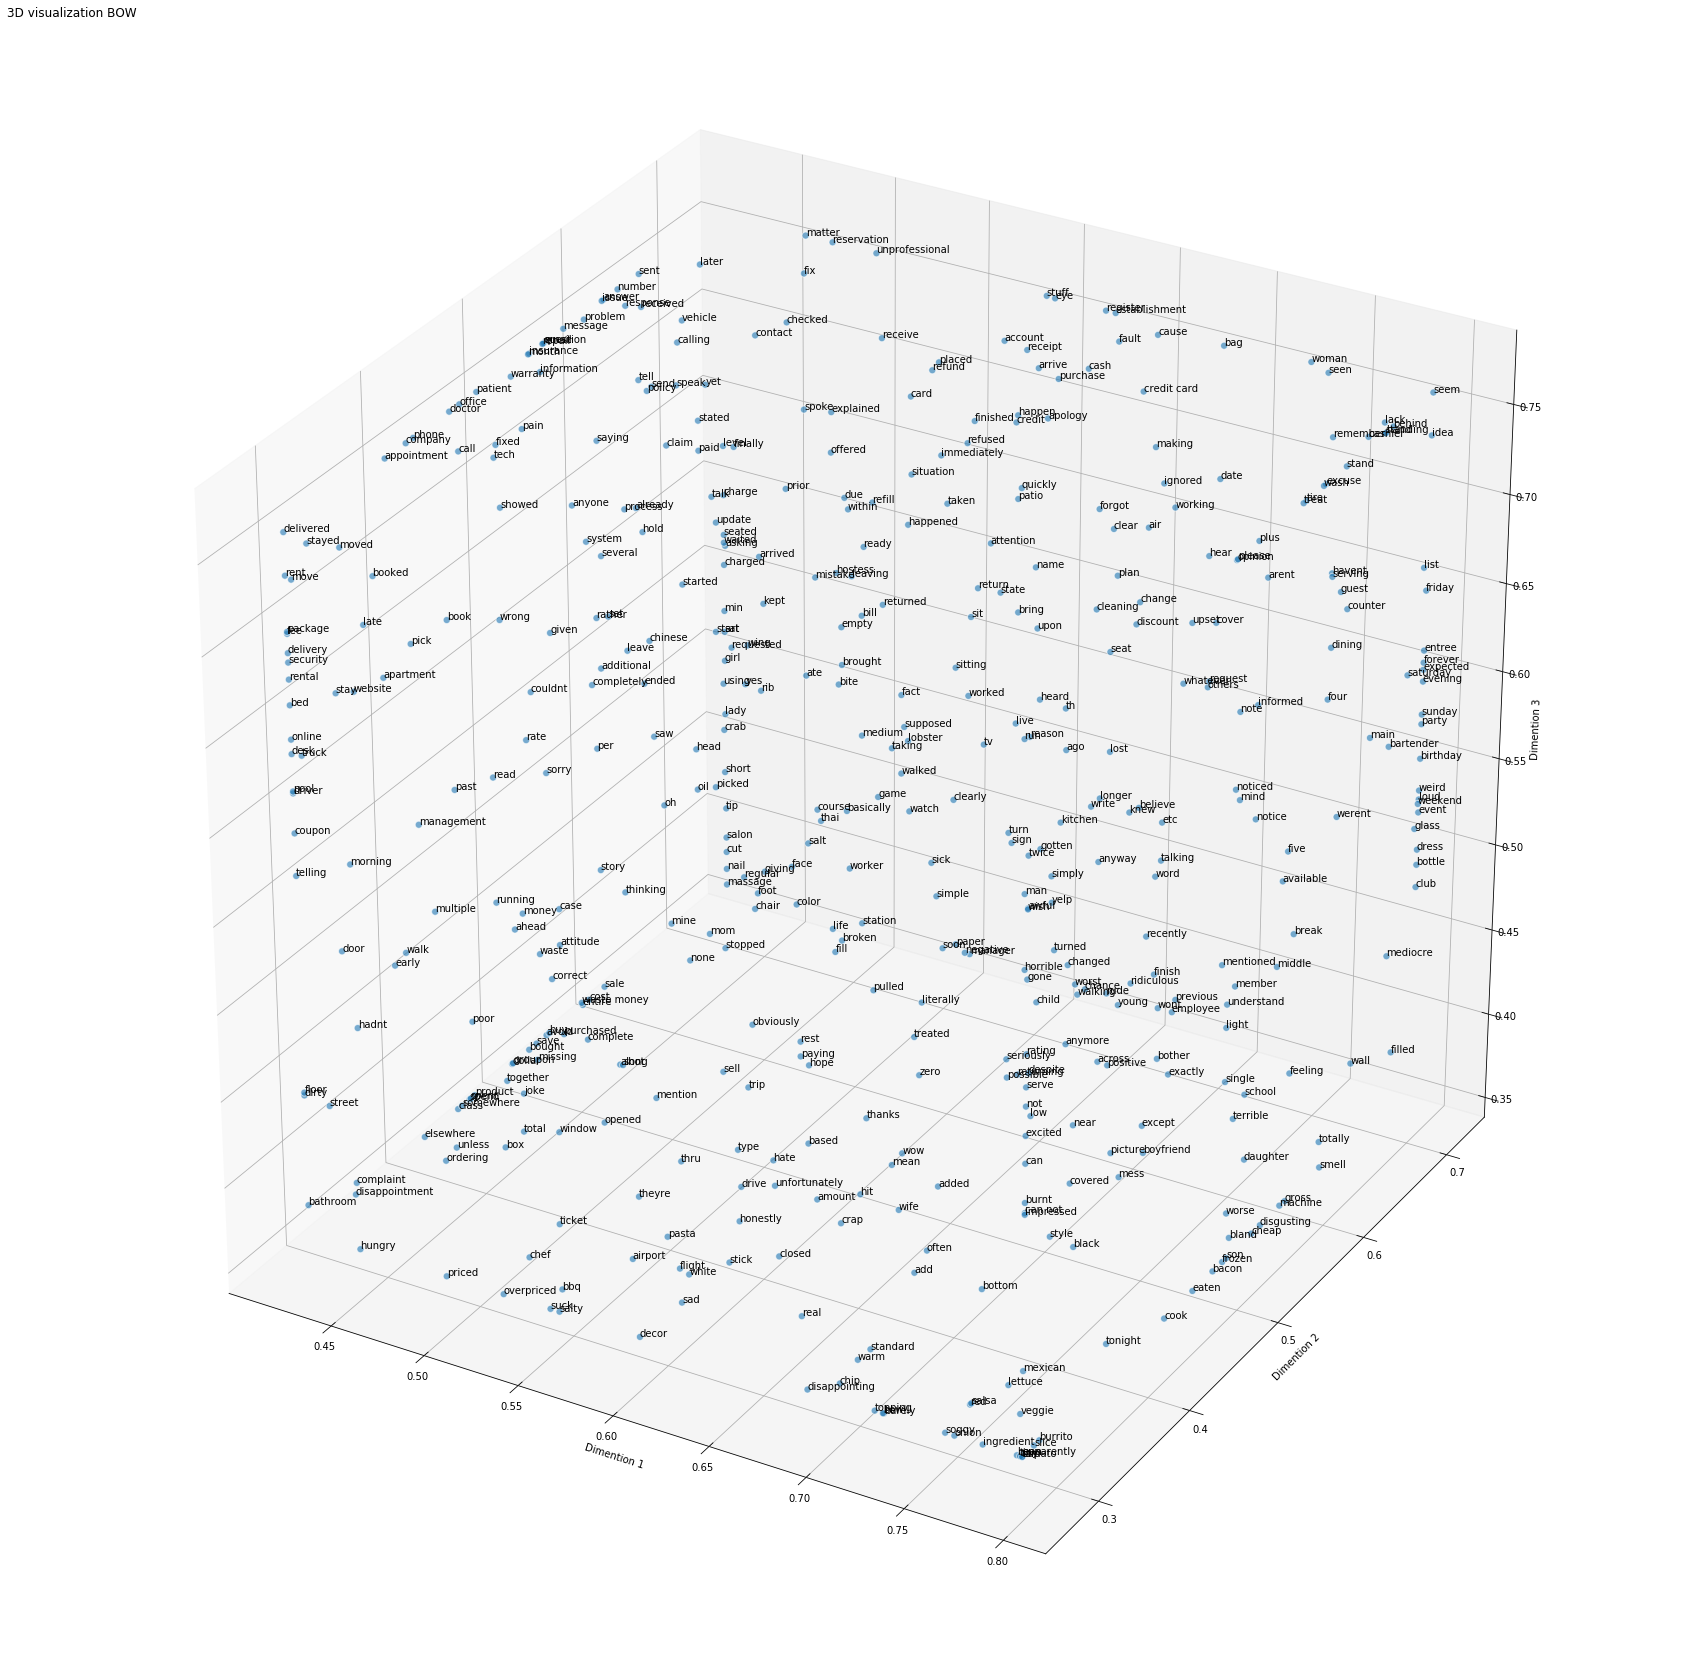

In [54]:
visualize(do,bowtfidf.columns)

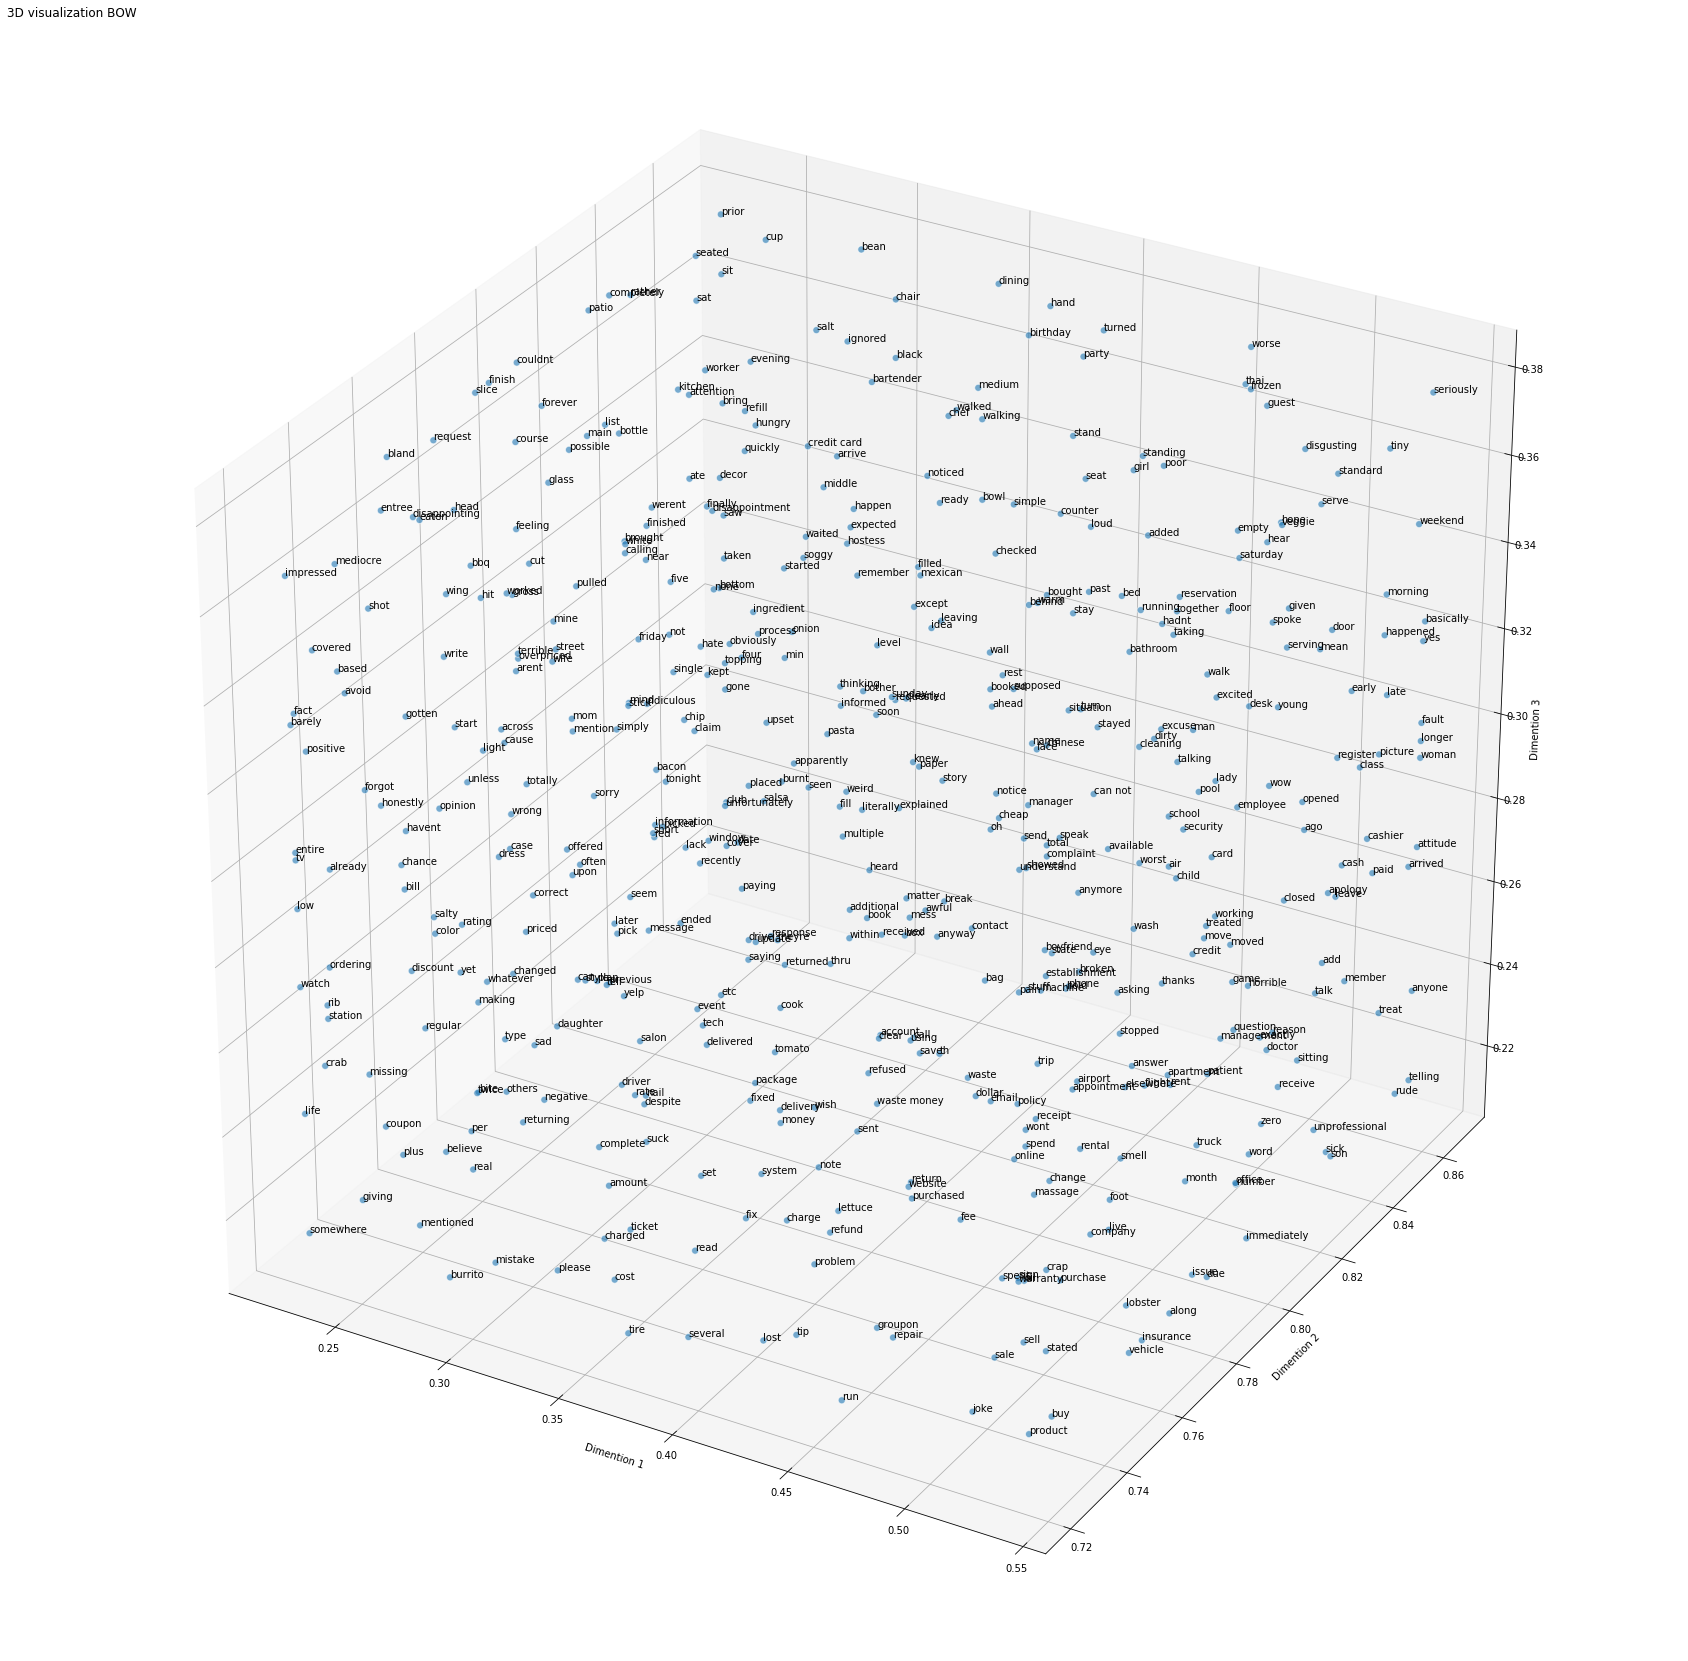

In [55]:
visualize(bowtfidf.T,bowtfidf.columns)

### BOW 3D Visualization with help of TSNE

In [32]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D1"]].sort_values(by="D1",ascending=False)[:10]


,fetuares,D1
300,please,0.676786
82,cleaning,0.676786
127,due,0.676786
311,problem,0.676786
121,doctor,0.676786
225,longer,0.676786
113,desk,0.676786
227,loud,0.676786
302,policy,0.676786
201,informed,0.676786


In [33]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D2"]].sort_values(by="D2",ascending=False)[:10]


,fetuares,D2
365,seated,0.734378
91,completely,0.734378
136,entree,0.734378
124,dress,0.734378
358,sat,0.734378
361,saw,0.734378
364,seat,0.734378
374,serving,0.734378
381,sign,0.734378
97,couldnt,0.734378


In [34]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D3"]].sort_values(by="D3",ascending=False)[:10]


,fetuares,D3
499,zero,0.544312
363,school,0.544312
220,light,0.544312
375,set,0.544312
96,cost,0.544312
204,insurance,0.544312
202,ingredient,0.544312
49,bought,0.544312
380,sick,0.544312
192,hope,0.544312


## Photos classification
The dataset contains the following labels

In [39]:
photosData= pd.read_json("photo.json", lines=True)

In [42]:
m=photosData['label'].value_counts()
m

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

### Available Photos

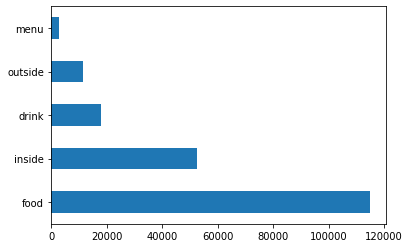

In [43]:
m.plot(kind="barh")

### Sorting photos into corresponding folders

In [33]:
import shutil
for i, row in photosData.iterrows():
    label= row['label']
    id=row['photo_id']
    if os.path.isfile("yelp_photos/photos/"+id+".jpg"):
        os.rename("yelp_photos/photos/"+id+".jpg", "yelp_photos/"+label+"/"+id+".jpg")

In [56]:

def getFeatures(path,sampleSize):
    allFeatures=[]
    hh=0
    for filename in os.listdir(path):
        
        ll=preProcess(path,filename)
        rr=runORB(ll)
        allFeatures.append(rr[1])#array[ImageNb][FeatureNb]
        hh=hh+1
        if(hh==sampleSize):
            return allFeatures
    

def preProcess(path,filename):
    img = cv2.imread(path+filename)
    img1 = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
    mask = nm.zeros(img1.shape[:2],nm.uint8)
    bgdModel = nm.zeros((1,65),nm.float64)
    fgdModel = nm.zeros((1,65),nm.float64)
    rect = (5,5,235,235)
    cv2.grabCut(img1,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
    mask2 = nm.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = img1*mask2[:,:,nm.newaxis]
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    #img1= cv2.GaussianBlur(img1,(5,5),cv2.BORDER_DEFAULT)
    ll=cv2.equalizeHist(img1)
    return ll


def runORB(ll):
    orb = cv2.ORB_create(nfeatures=100)
    keypoints, descriptors = orb.detectAndCompute(ll, None)
    return [keypoints, descriptors]

    

In [74]:
def runKmeans(allFeatures):
    kmeans = KMeans(n_clusters = 200, n_init=10)
    gg=[item for sublist in allFeatures for item in sublist]
    kmeans.fit(gg)#vocabulary
    #visual_words = kmeans.cluster_centers_
    return kmeans

In [75]:

def calcTf(kmeans, allFeatures):
    alla=[]
    for i in allFeatures:
        clusters=[]
        for u in i:
            cluster=kmeans.predict([u])  
            clusters.append(cluster[0])
        
        nums=pd.Series(clusters).value_counts()
        tf=nums.apply(lambda a:a/nums.sum())
        alla.append(tf.to_dict())
#tf for each feature in the document
    return alla

def calcDocsPerFeature(alla,clusters):
    documentsPerFeature=[0] * clusters
    for i in alla:
        for k in i:
            documentsPerFeature[k-1]=documentsPerFeature[k-1]+1
#number of documents containing the feature
    return documentsPerFeature

def calcTfIdf(alla,documentsPerFeature):
    fr= pd.DataFrame(columns= range(1,201))
    for i in alla:
        row=[0]*200
        totalWords=0
        for k in i:
            idf=m.log(len(alla)/documentsPerFeature[k-1])
            res=i[k]*idf
            row[k]=res
        fr=fr.append(pd.Series(row, range(1,201)),ignore_index=True )  
    return fr   

### Image preprocessing
- background removal
- noise removal
- histogram equalization
- resize to 240x240

### Extracting features from n images with help of ORB
- sample of 200 photos
- each photo gets up to 100 features

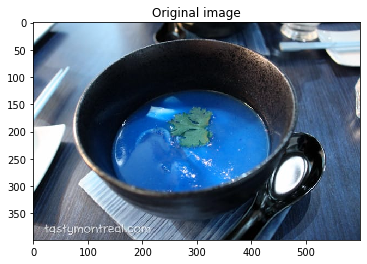

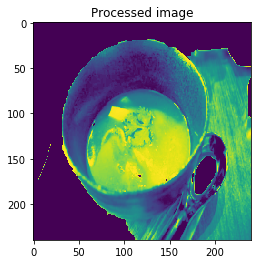

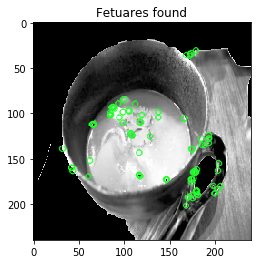

In [67]:
#Tesing image processing and feature generating functions
im= cv2.imread("yelp_photos/food/photo1.jpg")
plt.imshow(im)
plt.title("Original image")
plt.show()
im=preProcess("yelp_photos/food/","photo1.jpg")
plt.title("Processed image")
plt.imshow(im)
plt.show()
ress= runORB(im)
im=cv2.drawKeypoints(im,ress[0],im,color=(30,255,40), flags=0)
plt.title("Fetuares found")
plt.imshow(im)
plt.show()


In [72]:
allFeatures=getFeatures('yelp_photos/food/',200)


### Clustering into n clusters
- 200 clusters

In [76]:
kmeans=runKmeans(allFeatures)

### Calculating TF IDF and creating BOW

In [79]:
alla=calcTf(kmeans, allFeatures)
documentsPerFeature=calcDocsPerFeature(alla,200)
fr=calcTfIdf(alla,documentsPerFeature)
fr

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,0.041202,0.000000,0.000000,0.014963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.052676,0.000000,0.000000,0.024919,0.0,0.000000,0.0
1,0.026896,0.000000,0.000000,0.000000,0.014866,0.010079,0.014234,0.013639,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012200,0.014032,0.000000,0.0,0.013448,0.0
2,0.000000,0.011086,0.000000,0.000000,0.014866,0.000000,0.000000,0.000000,0.014032,0.000000,...,0.023738,0.000000,0.045255,0.012895,0.000000,0.000000,0.012200,0.0,0.094134,0.0
3,0.000000,0.000000,0.024999,0.014805,0.000000,0.000000,0.043152,0.000000,0.014180,0.024656,...,0.011994,0.014180,0.000000,0.000000,0.012328,0.000000,0.012328,0.0,0.000000,0.0
4,0.000000,0.011202,0.000000,0.000000,0.000000,0.000000,0.000000,0.013782,0.000000,0.024656,...,0.023988,0.000000,0.030488,0.000000,0.012328,0.000000,0.000000,0.0,0.054357,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.000000,0.000000,0.000000,0.015182,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.024919,0.000000,0.000000,0.0,0.013734,0.0
196,0.013448,0.011086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.014032,0.000000,0.012895,0.000000,0.000000,0.000000,0.0,0.000000,0.0
197,0.000000,0.000000,0.000000,0.029925,0.000000,0.000000,0.029074,0.027858,0.000000,0.012459,...,0.000000,0.014331,0.000000,0.026338,0.000000,0.042992,0.012459,0.0,0.000000,0.0
198,0.013882,0.000000,0.000000,0.030247,0.000000,0.010404,0.000000,0.014079,0.000000,0.000000,...,0.012252,0.000000,0.000000,0.013310,0.000000,0.000000,0.000000,0.0,0.000000,0.0


### Visualizing fetuares in 3D dimention scatter plot

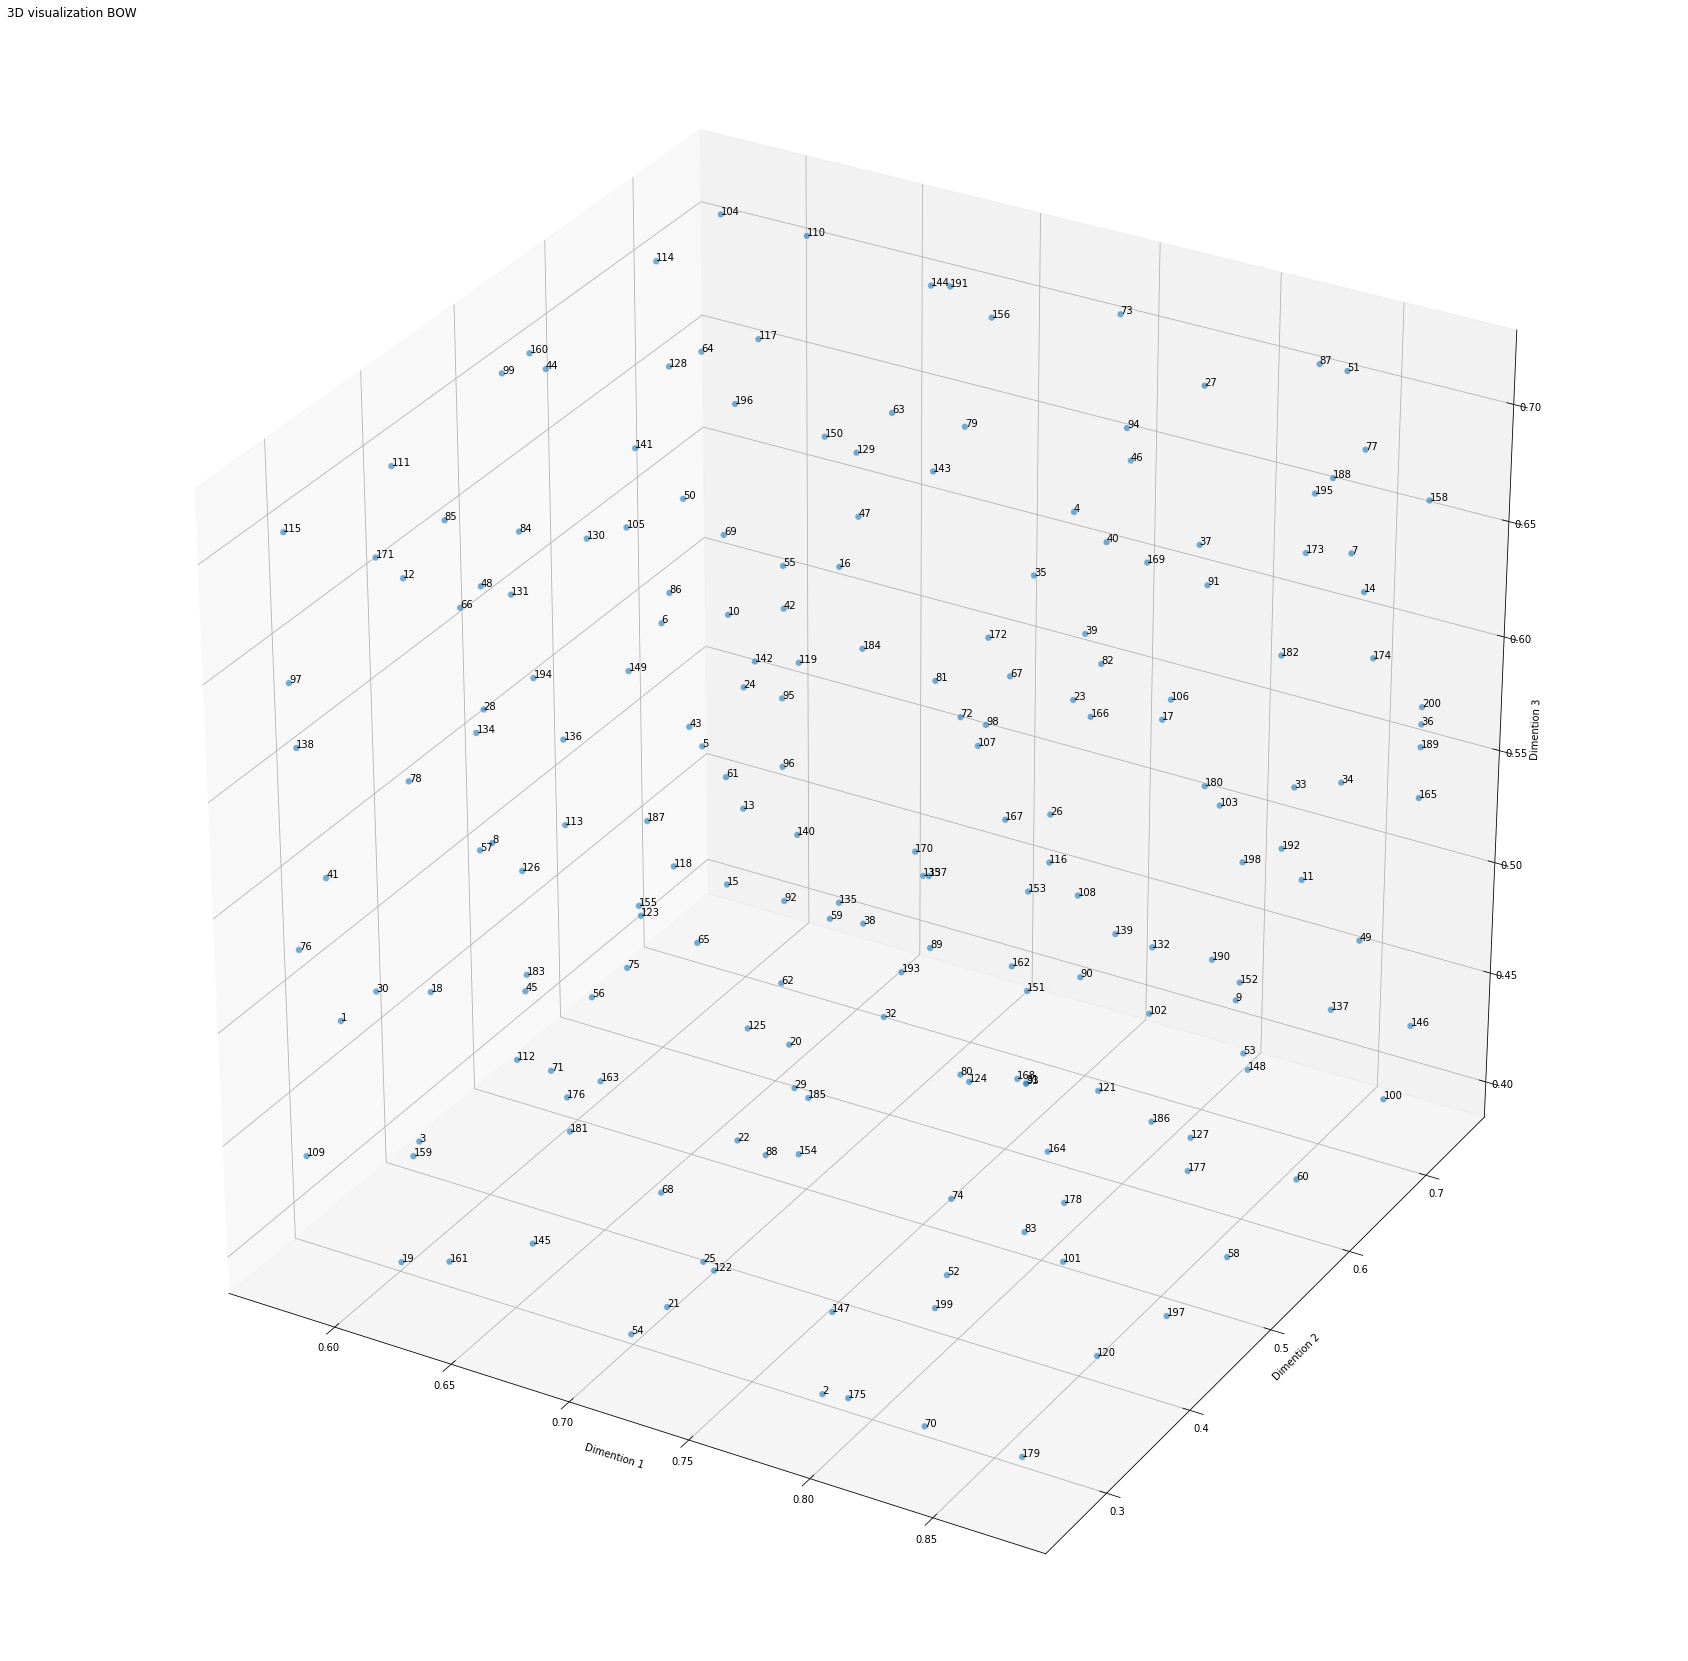

In [80]:
visualize(fr.T,fr.columns)

In [115]:
'''
y1=int(keypoints[0].pt[1]+keypoints[0].size/2)
y2=int(keypoints[0].pt[1]-keypoints[0].size/2)
x1= int(keypoints[0].pt[0]+keypoints[0].size/2)
x2=int(keypoints[0].pt[0]-keypoints[0].size/2)
crop_img = wholeImage[y2:y1,x2:x1]
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
'''

91
60
2189
2158


## YELP API Data Extraction
- get reviews, sorted by rating, business located in Deli
- apply filter:rating <3 
- save in the corresponding file

In [73]:
import json
import requests
import csv

key='crsZaDRn86h5i2YZhSlC4XdB_vunuNAQzIbUIH_wf_zN5OugkI116aSvccoHMLN5DPVb1RJYwWJUq1ns4SbjmiTFmZVmJkl5wegiKt3qS-2YsOLUFevIv8cGdmhVXnYx'
headers = {
    'Authorization': 'Bearer '+key,
    'Content-Type': 'application/graphql',
}

data = '{search(sort_by:"reviews",location:"mainz" limit:50) {business { reviews{rating text} }}}'

response = requests.post('https://api.yelp.com/v3/graphql', headers=headers, data=data)

json_obj = json.loads(response.content)
json_obj



arr=[]

for i in json_obj['data']['search']['business']:
    for u in i['reviews']:
        if(len(u)>0 and u['rating']<3):
            arr.append({'rating':u['rating'],'text':u['text']})


pd.DataFrame(arr).to_csv('data.csv', mode='a', header=False, index= False)
arr

[{'rating': 1,
  'text': 'This place was extremely disappointing.  The food was overly seasoned and the fish tasted very old and gamy.\n\nThe service was even worse as a large party...'},
 {'rating': 1,
  'text': 'Definitely did not meet expectations. Was clean and looked decent from the outside, and prices seemed more than reasonable but usually things that are too...'},
 {'rating': 2,
  'text': 'I hate to rate this restaurant at 2 stars, however, after my recent experience last night I left disappointed. I visited this restaurant in November and...'},
 {'rating': 1,
  'text': "Cheap wanna be Japanese restaurant. It actually doesn't taste anything Japanese the only flavor is sweet and nothing feels fresh. It is actually expensive..."},
 {'rating': 2,
  'text': 'Had a quick bite to eat for dinner here.\nIt was busy with an assortment of people.\nThey had a. English menu which was great.\nFor starters my husband and I...'},
 {'rating': 2,
  'text': 'I was excited by the number of vegeta